# Licensing Board EDA: License JSON Data

This notebook performs an exploratory data analysis on the extracted JSON licenses.

<span style="color: red; font-weight: bold;">NOTE: Be sure to run the pipeline first (run_pipeline.sh)</span>

In [2]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Settings
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 100)

json_dir = "../data/license_json"
source_dir = Path("../data/license_text")
target_dir = Path("../data/license_text_fix")

## 1. Load Data

Read all `.json` files from the `license_json` directory and combine them into a single DataFrame.

In [3]:
data = []

if os.path.exists(json_dir):
    files = [f for f in os.listdir(json_dir) if f.endswith(".json")]
    print(f"Found {len(files)} JSON files.")

    for filename in files:
        with open(os.path.join(json_dir, filename)) as f:
            try:
                record = json.load(f)
                data.append(record)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
else:
    print(f"Error: {json_dir} directory not found.")

df = pd.DataFrame(data)
print(f"DataFrame created with {len(df)} rows and {len(df.columns)} columns.")

Found 2363 JSON files.
DataFrame created with 2363 rows and 15 columns.


## 2. Basic Statistics

Overview of the dataset structure and missing values.

In [4]:
import pandas as pd
from IPython.display import display

# ---------------------
# Data Info
# ---------------------
info_df = pd.DataFrame({"Column": df.columns, "Non-Null Count": df.notnull().sum()})

# Display using the original numeric column for gradient, but show formatted column
display(
    info_df.style.hide(axis="index")
    .set_caption("License JSON Summary")
    .background_gradient(cmap="Blues", subset=["Non-Null Count"])
)

Column,Non-Null Count
minutes_date,2363
license_number,2363
business_name,2363
dba_name,2148
address,2354
zipcode,2353
alcohol_type,2256
manager,1061
attorney,1472
status,2307


In [5]:
# Missing Values
null_counts = df.isnull().sum()
nulls_df = null_counts[null_counts >= 0].reset_index()
nulls_df.columns = ["Column", "Null Count"]
display(
    nulls_df.style.set_caption("Missing Values")
    .hide(axis="index")
    .bar(subset=["Null Count"], color="red")
)

Column,Null Count
minutes_date,0
license_number,0
business_name,0
dba_name,215
address,9
zipcode,10
alcohol_type,107
manager,1302
attorney,891
status,56


# 3. Extract specific field for deeper evaluation

| Name             | Description |
|-----------------|-------------|
| minutes_date     | Date of the hearing or meeting. |
| license_number   | Unique identifier for the business license. |
| business_name    | Official registered name of the business. |
| dba_name         | "Doing Business As" name, if different from the registered name. |
| address          | Street address of the business. |
| zipcode          | ZIP code of the business location. |
| alcohol_type     | Type of alcohol license (e.g., beer, wine, all alcoholic beverages). |
| manager          | Name of the business manager or license holder. |
| attorney         | Name of the attorney representing the business, if any. |
| status           | Current status of the license (e.g., active, expired, suspended). |
| status_detail    | Additional details about the license status. |
| hours            | Authorized operating hours for the business. |
| details          | Any extra notes or relevant information from the hearing. |
| entity_number    | Internal entity number extracted from source files. |
| file_name        | Source file name from which the record was extracted. |


In [6]:
# Create subset of records where <field_name> is missing
field_name = "alcohol_type"
subset = df[df[field_name].isna()][["file_name", "entity_number"]]
subset["new_filename"] = (
    subset["file_name"].str.replace(r"\.txt$", "", regex=True)
    + "_"
    + subset["entity_number"].astype(str)
    + ".txt"
)
print(f"Found {len(subset)} records where {field_name} is missing")

Found 107 records where alcohol_type is missing


In [7]:
# Copy found files to license_text_fix directory for manual review

import shutil
from pathlib import Path

# Ensure target directory exists
target_dir.mkdir(exist_ok=True)

# --- Delete any existing files in target_dir ---
for f in target_dir.iterdir():
    if f.is_file():
        f.unlink()  # delete file
    elif f.is_dir():
        shutil.rmtree(f)  # delete subdirectory if any

print(f"Cleared existing files in {target_dir}")

# Copy found files to target_dir for manual review
count = 0
for _, row in subset.iterrows():
    src = source_dir / row["new_filename"]  # original file
    dst = target_dir / row["new_filename"]  # renamed file
    count += 1
    # print(f"Copying: {src} → {dst}")

    try:
        shutil.copy2(src, dst)  # preserves metadata
    except FileNotFoundError:
        print(f"⚠️ Source file not found: {src}")
    except Exception as e:
        print(f"⚠️ Error copying file {src} → {dst}: {e}")

print(f"Copied {count} files to {target_dir}")

Cleared existing files in ../data/license_text_fix
Copied 107 files to ../data/license_text_fix


## 4. Categorical Distributions

Visualizing the values of `status`, `category`, and `zipcode`.

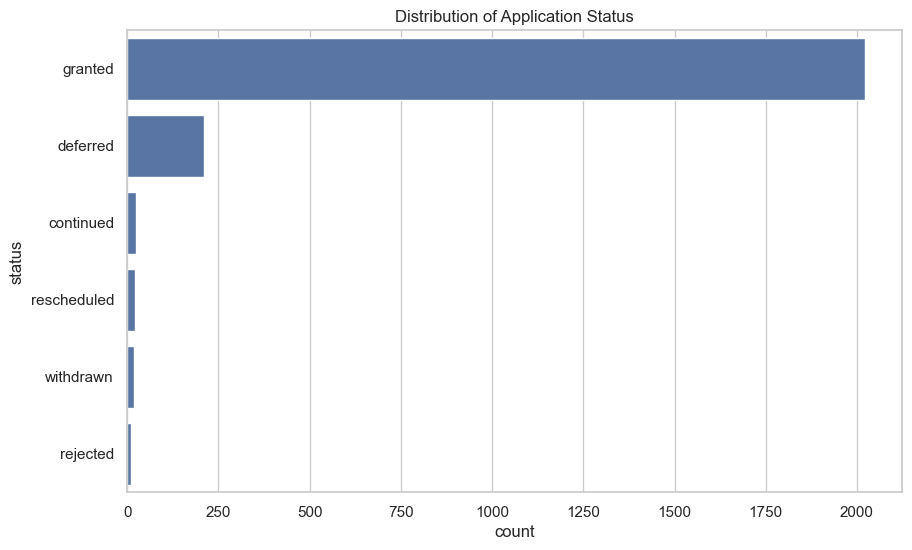

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y="status", order=df["status"].value_counts().index)
plt.title("Distribution of Application Status")
plt.show()

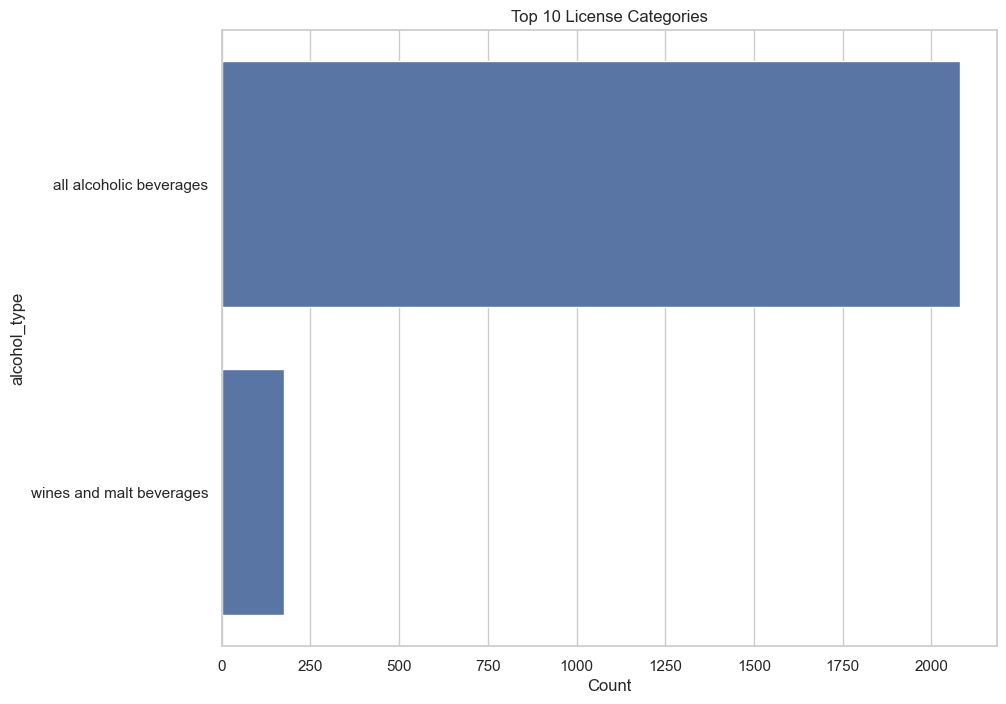

In [23]:
plt.figure(figsize=(10, 8))
top_categories = df["alcohol_type"].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 License Categories")
plt.xlabel("Count")
plt.show()

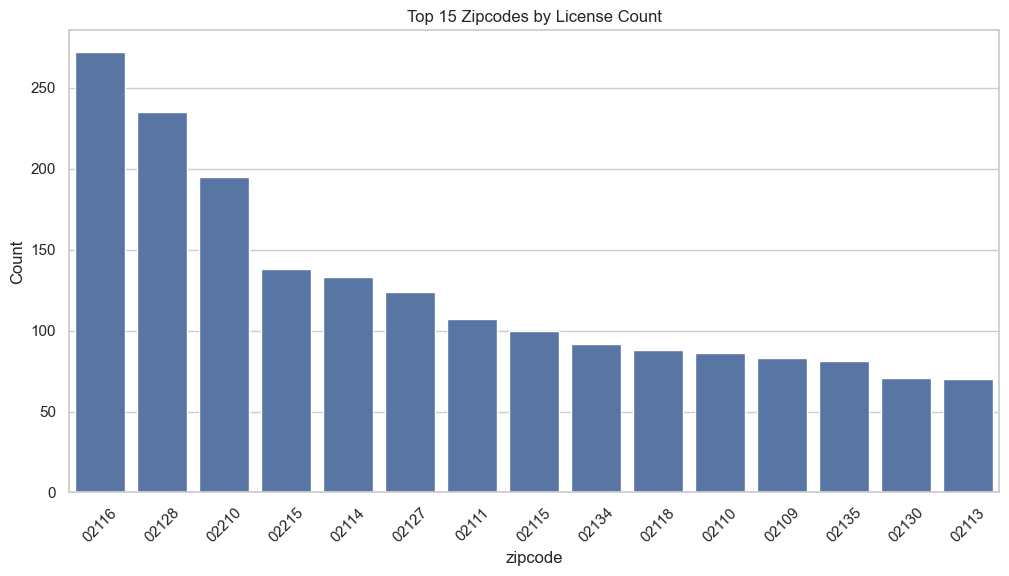

In [24]:
plt.figure(figsize=(12, 6))
top_zipcodes = df["zipcode"].value_counts().head(15)
sns.barplot(x=top_zipcodes.index, y=top_zipcodes.values)
plt.title("Top 15 Zipcodes by License Count")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## 5. Text Analysis (Basic)

Distribution of record lengths in `details` or presence of certain fields.

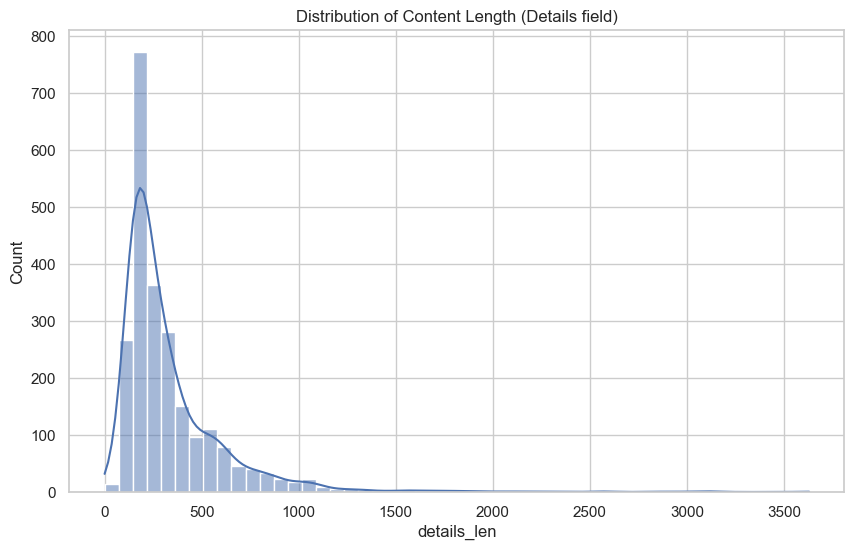

In [25]:
df["details_len"] = df["details"].str.len().fillna(0)
plt.figure(figsize=(10, 6))
sns.histplot(df["details_len"], bins=50, kde=True)
plt.title("Distribution of Content Length (Details field)")
plt.show()

In [27]:
import pandas as pd
from IPython.display import display

unique_count = df["license_number"].nunique()
counts = df["license_number"].value_counts()

summary_df = counts.reset_index()
summary_df.columns = ["License Number", "Occurrences"]

display(
    pd.DataFrame(
        {"Metric": ["Unique License Numbers"], "Value": [f"{unique_count:,}"]}
    ).style.hide(axis="index")
)

# Show only top 10
top10_df = summary_df.head(10)


display(
    top10_df.style.hide(axis="index")
    .set_caption("Top 10 Most Frequent License Numbers")
    .background_gradient(cmap="Blues", subset=["Occurrences"])
)

Metric,Value
Unique License Numbers,"1,508"


License Number,Occurrences
LB-99098,8
LB-99425,7
LB-485388,7
LB-98819,7
LB-99080,6
LB-99386,6
LB-98972,6
LB-101660,6
LB-99404,6
LB-163968,6


## 6. Temporal Analysis

Analyzing the distribution of hearings over time.

In [28]:
# Convert hearing_date to datetime
df["minutes_date"] = pd.to_datetime(df["minutes_date"], errors="coerce")

# Create year and month features
df["year"] = df["minutes_date"].dt.year
df["month"] = df["minutes_date"].dt.month
df["month_name"] = df["minutes_date"].dt.month_name()

print(f"Total records with valid dates: {df['minutes_date'].notnull().sum()}")
print(f"Records with missing dates: {df['minutes_date'].isnull().sum()}")

Total records with valid dates: 2352
Records with missing dates: 11


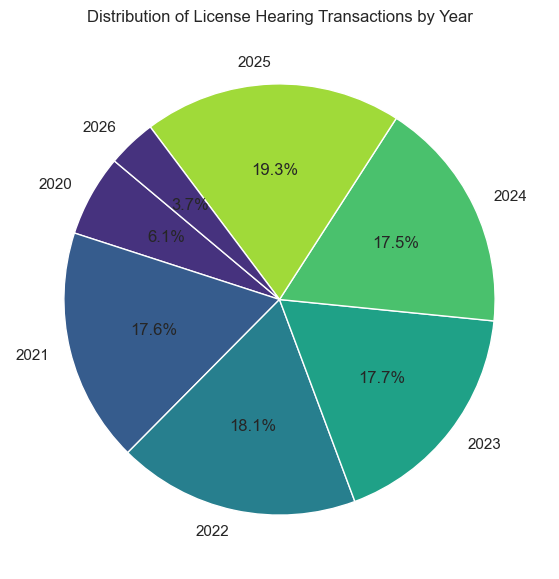


### License Hearing Transactions per Year


,Count
year,
2020.0,144
2021.0,413
2022.0,426
2023.0,417
2024.0,411
2025.0,455
2026.0,86


In [ ]:
# Yearly Distribution
# 2020 Looks low maybe because of the pandemic?
# Maybe we dont have all the data for that year?
#
plt.figure(figsize=(10, 7))
year_counts = df["year"].value_counts().sort_index()
if not year_counts.empty:
    plt.pie(
        year_counts,
        labels=year_counts.index.astype(int).tolist(),
        autopct="%1.1f%%",
        startangle=140,
        colors=sns.color_palette("viridis"),
    )
    plt.title("Distribution of License Hearing Transactions by Year")
    plt.show()

    print("\n### License Hearing Transactions per Year")
    display(year_counts.to_frame(name="Count"))
else:
    print("No yearly data available.")

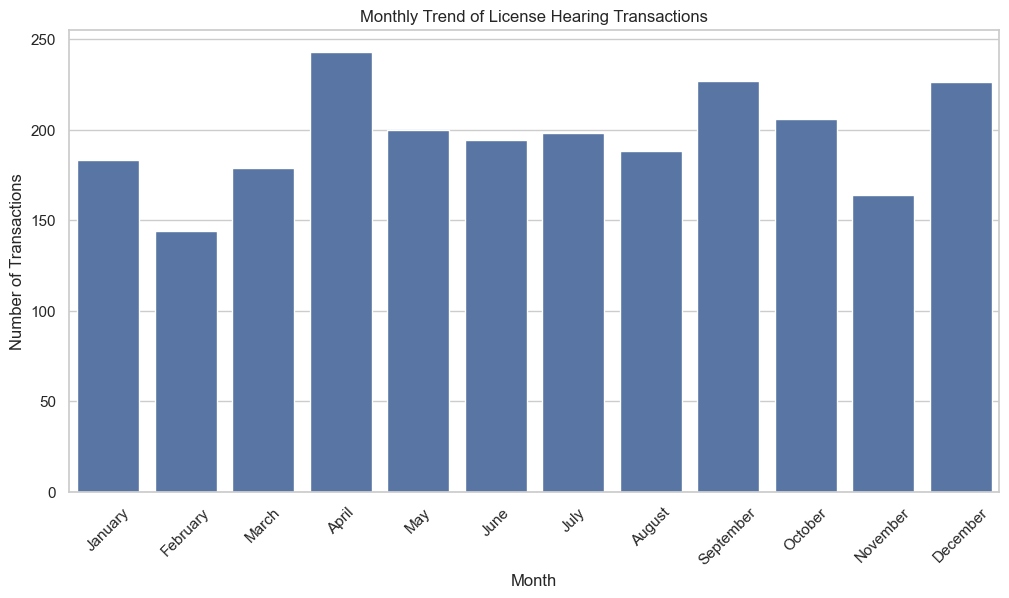

In [ ]:
# How many hearing transactions per month?

plt.figure(figsize=(12, 6))
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
sns.countplot(data=df[df["month_name"].notnull()], x="month_name", order=month_order)
plt.title("Monthly Trend of License Hearing Transactions")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

/var/folders/jq/7cv336vx66v_c3vj7vwrpt6c0000gn/T/ipykernel_21048/1124763468.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_years['year'] = df_years['year'].astype(int)


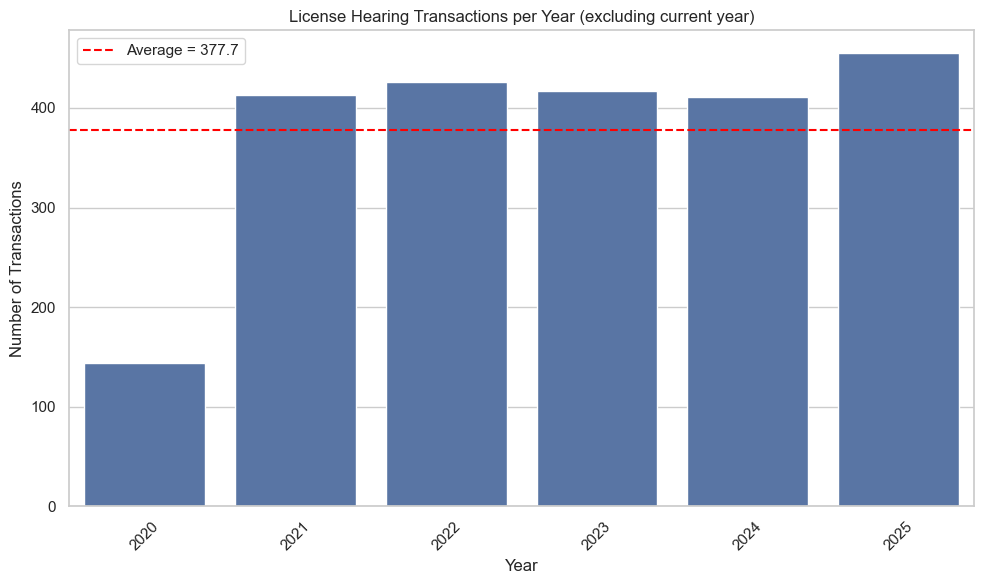

Current year (2026) count before dropping: 86
Transactions per year (excluded current year):
year
2020    144
2021    413
2022    426
2023    417
2024    411
2025    455

Total transactions (excluding 2026): 2266

Total transactions: 2352

Average transactions per year (excluding 2026): 377.67


In [40]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Ensure hearing_date is datetime (we already did this, but safe to repeat) ---
df = df.copy()
df["minutes_date"] = pd.to_datetime(df["minutes_date"], errors="coerce")

# --- Year counts ---
df["year"] = df["minutes_date"].dt.year
# drop rows with missing year
df_years = df[df["year"].notnull()]

# Convert year to int (after dropping NaT)
df_years["year"] = df_years["year"].astype(int)

# Count transactions per year
year_counts = (
    df_years.groupby("year").size().sort_index()
)  # Series: index=year, value=count

# --- Drop the current year (partial) ---
current_year_count = 0
current_year = datetime.now().year
if current_year in year_counts.index:
    current_year_count = year_counts.loc[current_year]
    year_counts = year_counts.drop(current_year)

# If there are no years left after dropping current year, warn and stop
if year_counts.empty:
    raise ValueError("No full-year data available after dropping the current year.")

# --- Compute average transactions per year ---
avg_transactions_per_year = year_counts.mean()

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(x=year_counts.index.astype(str), y=year_counts.values)
plt.axhline(
    avg_transactions_per_year,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Average = {avg_transactions_per_year:.1f}",
)
plt.title("License Hearing Transactions per Year (excluding current year)")
plt.xlabel("Year")
plt.ylabel("Number of Transactions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Print summary ---
print(f"Current year ({current_year}) count before dropping: {current_year_count}")
print("Transactions per year (excluded current year):")
print(year_counts.to_string())

total_transactions = year_counts.sum()
print(f"\nTotal transactions (excluding {current_year}): {total_transactions}")
print(f"\nTotal transactions: {total_transactions + current_year_count}")

print(
    f"\nAverage transactions per year (excluding {current_year}): {avg_transactions_per_year:.2f}"
)

In [43]:
license_list = [
    "LB-559007",
    "LB-99643",
    "LB-567244",
    "LB-570339",
    "LB-570350",
    "LB-476499",
    "LB-572966",
    "LB-574267",
    "LB-574154",
    "LB-574260",
    "LB-577182",
    "LB-577222",
    "LB-577208",
    "LB-577217",
    "LB-577220",
    "LB-578134",
    "LB-578141",
    "LB-578142",
    "LB-578145",
    "LB-578143",
    "LB-578144",
    "LB-578146",
    "LB-580946",
    "LB-580948",
    "LB-580949",
    "LB-580950",
    "LB-580951",
    "LB-580952",
    "LB-580953",
    "LB-581511",
    "LB-581512",
    "LB-580947",
    "LB-581522",
    "LB-581520",
    "LB-581524",
    "LB-582370",
    "LB-582381",
    "LB-582320",
    "LB-582328",
    "LB-582324",
    "LB-583839",
    "LB-583841",
    "LB-583884",
    "LB-583866",
    "LB-583877",
    "LB-584070",
    "LB-584080",
    "LB-584097",
    "LB-584103",
    "LB-584086",
    "LB-584345",
    "LB-584372",
    "LB-584369",
    "LB-584375",
    "LB-587125",
    "LB-587130",
    "LB-587134",
    "LB-587880",
    "LB-587892",
    "LB-588316",
    "LB-590954",
    "LB-592854",
    "LB-592817",
    "LB-592801",
    "LB-592818",
    "LB-592810",
    "LB-593664",
    "LB-593662",
    "LB-593698",
    "LB-593736",
    "LB-593791",
    "LB-593661",
    "LB-593758",
    "LB-595045",
    "LB-595032",
    "LB-595198",
    "LB-595036",
    "LB-595074",
    "LB-595024",
    "LB-596016",
    "LB-596018",
    "LB-596693",
    "LB-596687",
    "LB-596653",
    "LB-596679",
    "LB-597972",
    "LB-598023",
    "LB-598009",
    "LB-598072",
    "LB-597998",
    "LB-598021",
    "LB-599543",
    "LB-599562",
    "LB-599554",
    "LB-599561",
    "LB-599551",
    "LB-599529",
    "LB-601426",
    "LB-601427",
    "LB-601428",
    "LB-601455",
    "LB-601425",
    "LB-601416",
    "LB-603744",
    "LB-603766",
    "LB-603681",
    "LB-603690",
    "LB-603763",
    "LB-605364",
    "LB-605351",
]
print(f"Number of current licenses use in app: {len(license_list)}")

Number of current licenses use in app: 110


In [ ]:
# Convert hearing_date to datetime for proper sorting
# Save to a CSV so we can more easily evaluate with Excel

df["minutes_date_dt"] = pd.to_datetime(df["minutes_date"], errors="coerce")

# Filter matches
matched_df = df[df["license_number"].isin(license_list)]

# Sort by newest hearing_date first
matched_df = matched_df.sort_values("minutes_date_dt", ascending=False)

# Save to CSV
matched_df.to_csv("matched_licenses_sorted.csv", index=False)

In [45]:
missing = [lic for lic in license_list if lic not in set(df["license_number"])]
print(missing)

[]
